In [28]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from sklearn.datasets import fetch_openml, load_boston, load_diabetes
import pandas as pd
import time, sys, os
from sklearn.model_selection import train_test_split

# import models
# installable with: `pip install git+https://github.com/csinva/interpretability-implementations-demos`

from sklearn.tree import DecisionTreeRegressor, plot_tree
from imodels import SLIM, RuleListClassifier, RuleFit, GreedyRuleList


# load (regression) data on boston housing prices
def get_reg_boston_data():
    X, y = load_boston(return_X_y=True)
    feature_names = load_boston()['feature_names']
    return X, y, feature_names

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### short decision tree

train mse: 15.38


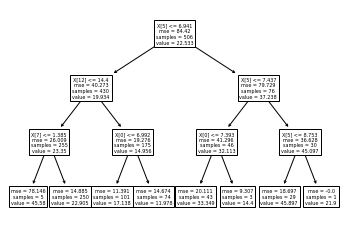

In [29]:
# load in some data
X, y, features = get_reg_boston_data()

# specify a decision tree with a maximum depth
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(X, y)

# calculate mse on the training data
preds = dt.predict(X)
print(f'train mse: {np.mean(np.square(preds-y)):0.2f}')

plot_tree(dt)
plt.savefig('tree.pdf')
plt.show()

### integer linear models

In [4]:
np.random.seed(123)

# generate X and y
n, p = 1000, 10
X = np.random.randn(n, p)
y = X[:, 0] + 2 * X[:, 1] - 1 * X[:, 2] + np.random.randn(n)

# fit linear models with different regularization parameters
model = SLIM()
for lambda_reg in [0, 1e-2, 5e-2, 1e-1, 1, 2]:
    model.fit(X, y, lambda_reg)
    mse = np.mean(np.square(y - model.predict(X)))
    print(f'lambda: {lambda_reg}\tmse: {mse: 0.2f}\tweights: {model.model.coef_}')

lambda: 0	mse:  2.87	weights: [0 2 0 0 0 0 0 0 0 0]
lambda: 0.01	mse:  2.87	weights: [0 2 0 0 0 0 0 0 0 0]
lambda: 0.05	mse:  2.87	weights: [0 2 0 0 0 0 0 0 0 0]
lambda: 0.1	mse:  2.09	weights: [ 1  1 -1  0  0  0  0  0  0  0]
lambda: 1	mse:  2.87	weights: [0 2 0 0 0 0 0 0 0 0]
lambda: 2	mse:  2.87	weights: [0 2 0 0 0 0 0 0 0 0]


### rulefit
- [documentation](https://github.com/christophM/rulefit) and the [original paper](http://statweb.stanford.edu/~jhf/ftp/RuleFit.pdf)

In [5]:
# load some data
X, y, feature_names = get_reg_boston_data()

# fit a rulefit model
rf = RuleFit()
rf.fit(X, y, feature_names=feature_names)

# calculate mse on the training data
preds = rf.predict(X)
print(f'train mse: {np.mean(np.square(preds-y)):0.2f}')

train mse: 2.04


/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.125242615225943, tolerance: 4.2716295415019765
  positive)


now, let's inspect the rules

In [6]:
rules = rf.get_rules()

rules = rules[rules.coef != 0].sort_values("support", ascending=False)

# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is how many points it applies to
rules[['rule', 'coef', 'support']].head().style.background_gradient(cmap='viridis')

,rule,coef,support
1,zn,0.00823711,1
6,age,-0.0205571,1
721,rm <= 8.386499881744385 & dis > 1.3007500171661377,-0.0656153,0.974359
134,rm > 4.984999895095825 & dis > 1.1857500076293945,-0.662768,0.961538
1291,rm <= 7.494999885559082 & dis > 1.1716500520706177,-1.41123,0.935897


### greedy rule lists
**like a decision tree that only ever splits going left**

shapes (768, 8) (768,)
mean 0.3489583333333333
mean 0.19381443298969073
mean 0.08487084870848709
mean 0.013245033112582781
mean 0.006666666666666667


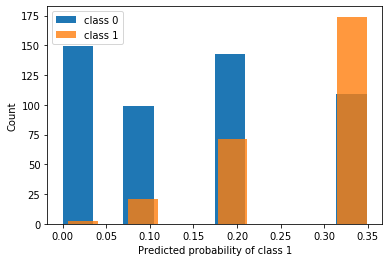

In [64]:
# load some data
data = fetch_openml("diabetes") # get dataset
y = (data.target == 'tested_positive').astype(np.int) # labels 0-1
X = data.data
print('shapes', X.shape, y.shape)

# fit a rulefit model
m = GreedyRuleList()
m.fit(X, y=y, feature_names=data.feature_names) # stores into m.rules_
probs = m.predict_proba(X)
print(m)

# look at prediction breakdown
plt.hist(probs[:, 1][y==0], label='class 0')
plt.hist(probs[:, 1][y==1], label='class 1', alpha=0.8)
plt.ylabel('Count')
plt.xlabel('Predicted probability of class 1')
plt.legend()
plt.show()

### scalable bayesian rule lists

In [24]:
np.random.seed(13)

feature_labels = ["#Pregnant","Glucose concentration test","Blood pressure(mmHg)","Triceps skin fold thickness(mm)",
                  "2-Hour serum insulin (mu U/ml)","Body mass index","Diabetes pedigree function","Age (years)"]
data = fetch_openml("diabetes") # get dataset
X = data.data
y = (data.target == 'tested_positive').astype(np.int) # labels 0-1

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.75) # split

# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training...')
model = RuleListClassifier(max_iter=10000, class1label="diabetes", verbose=False)
model.fit(Xtrain, ytrain, feature_labels=feature_labels)

print("RuleListClassifier Accuracy:", model.score(Xtest, ytest), "Learned interpretable model:\n", model)
# print("RandomForestClassifier Accuracy:", RandomForestClassifier(n_estimators=10).fit(Xtrain, ytrain).score(Xtest, ytest))

/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/datasets/_openml.py:376: UserWarning: Multiple active versions of the dataset matching the name diabetes exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


training...
RuleListClassifier Accuracy: 0.7065972222222222 Learned interpretable model:
 Trained RuleListClassifier for detecting diabetes
IF #Pregnant : 6.5_to_inf THEN probability of diabetes: 65.7% (49.5%-80.3%)
ELSE IF Glucose concentration test : -inf_to_122.5 THEN probability of diabetes: 9.9% (4.9%-16.4%)
ELSE IF Body mass index : -inf_to_30.9 THEN probability of diabetes: 36.0% (18.8%-55.3%)
ELSE probability of diabetes: 69.2% (54.1%-82.5%)



### optimal classification tree
- docs [here](https://github.com/csinva/interpretability-workshop/tree/master/imodels/optimal_classification_tree)
- note: this implementation is still somewhat unstable, and can be made faster by installing either `cplex` or `gurobi`

In [3]:
sys.path.append('../imodels/optimal_classification_tree/pyoptree')
sys.path.append('../imodels/optimal_classification_tree/')

In [ ]:
from optree import OptimalTreeModel
feature_names = np.array(["x1", "x2"])

X = np.array([[1, 2, 2, 2, 3], [1, 2, 1, 0, 1]]).T
y = np.array([1, 1, 0, 0, 0]).reshape(-1, 1)
X_test = np.array([[1, 1, 2, 2, 2, 3, 3], [1, 2, 2, 1, 0, 1, 0]]).T
y_test = np.array([1, 1, 1, 0, 0, 0, 0])

np.random.seed(13)
model = OptimalTreeModel(tree_depth=3, N_min=1, alpha=0.1) #, solver_name='baron'
model.fit(X_test, y_test) # this method is currently using the fast, but not optimal solver
preds = model.predict(X_test)

# fit on the bigger diabetes dset from above
# model.fit(Xtrain, ytrain) # this method is currently using the fast, but not optimal solver
# preds = model.predict(Xtest)

print('acc', np.mean(preds == y_test))

In [10]:
model.print_tree(feature_names)

depth 0:
	 x2 > 0.8114524236945737

depth 1:
	node 2 undefined
	node 3 undefined

depth 2:
	node 4 undefined
	 x1 > 0.01086684288089712
	 x2 > 0.9159532769401844
	node 7 undefined

depth 3:
	node 8 undefined
	node 9 undefined
	node 10 undefined
	node 11 undefined
	node 12 undefined
	node 13 undefined
	node 14 undefined
	node 15 undefined

